# Advanced Lane Finding

This Jupyter notebook contains an application to find lane lines in a video captured from a dashcam while driving
on a highway.  The application is intended to satisfy the requirements for the Advanced Lane Finding project in
the Udacity Nanodegree on Self-Driving Car Engineering.

## Sample Inputs and Outputs

Here are examples of an input frame and the resulting output frame with the driving lane highlighted in green.

[//]: # (Image References)

<figure>
 <img src="test_images/straight_lines1.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Here is an example of an input frame from a video. </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/example_output.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The output should look something like this (above) after detecting
     left and right lane lines.</p> 
 </figcaption>
</figure>

# Imports
Here are the imported library objects required to support this application.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from itertools import chain
%matplotlib inline
#%matplotlib qt # to display in an interactive window
print()

# Helper Function Constants

In [2]:
#CHESS BOARD
CHESS_BOARD_ROWS = 9
CHESS_BOARD_COLS = 6

# Helper Functions
Here are the helper functions required by the application.

In [143]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is a blank image (all black) with lines or other figures drawn on it.
    
    `initial_img` is an image onto which img will be composited.
    
    The resulting image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_circles(img, centers, radii, colors, thickness=3):
    for i in range(len(centers)):
        #print("draw_circles: centers: ", centers, " radii: ", radii, " colors: ", colors)
        cv2.circle(img, centers[i], radii[i], colors[i], thickness=thickness)


## TODO: Some new facilities are needed or desired to keep the architecture pliable.
## 1) Hide the details about an image's origin and storage.  Functions which operate on image data
##    should not have to mess with file or network I/O, nor should they be allowed to know
##    what was or will be done with the image in prior and subsequent steps.
## 2) Hide details about the output of figures.  Image manipulation functions should not know
##    how or whether the objects it operates on will be written to any type of display.  This
##    requirement is similar to 1) above -- decouple processing from I/O.

def display_images(images, titles=[], shape=(0,0), figuresize=None):
    """
    Display a list of images and corresponding titles
    """
    
    col_width = 3
    
    if shape == (0,0):
        shape = (1 + len(images)//col_width, min(len(images), col_width))
    elif shape[0] == -1:
        shape = (len(images)//shape[1], shape[1])
    #print("shape: ", shape)
    
    title_deficiency = len(images) - len(titles)
    if title_deficiency > 0:
        titles.extend([None] * title_deficiency)
        
    #fig, axes = plt.subplots(shape[0], shape[1])
    fig = plt.figure()
    fig.tight_layout()
    fig.set_figheight(figuresize[0] if figuresize != None else 15)
    fig.set_figwidth(figuresize[1] if figuresize != None else 15)
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    
    for row in range(shape[0]):
        for col in range(shape[1]):
            if len(images) >= row * shape[1] + col + 1:
                a = fig.add_subplot(shape[0], shape[1], row * shape[1] + col + 1)
                a.set_title(titles[row * shape[1] + col])
                a.axis('off')
                a.set_xticks([])
                a.set_yticks([])
                img = images[row * shape[1] + col]
                color_map = 'gray' if (len(img.shape) <= 2) or (img.shape[2] <= 1) else None
                a.imshow(images[row * shape[1] + col], cmap=color_map)

def hls(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_h = hls[:,:,0]
    hls_l = hls[:,:,1]
    hls_s = hls[:,:,2]
    
    return hls_h, hls_l, hls_s
    
def hsv(img):
    img = np.copy(img)
    # Convert to HSV color space and separate the channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_h = hsv[:,:,0]
    hsv_s = hsv[:,:,1]
    hsv_v = hsv[:,:,2]
    
    return hsv_h, hsv_s, hsv_v

## 3) Logging facility for debugging.  Hopefully find an existing class.
## 4) Cacheing of intermediate artifacts, such as intermediate images, arrays, lists, etc. so they
##    can be accessed from other parts of the program without necessarily requiring that the
##    call tree be explicitly modified to pass them around.  Again, look for an existing library.
##    This can be valuable for making rapid changes for demonstration purposes, such as
##    when a last minute decision is made to add additional details to a plot.
## 5) A design which treats the pipeline itself as a container or network, allowing individual steps to be
##    inserted, removed or reordered on the fly.  This will require a reliable way of specifying
##    producers and consumers of specific data objects.  It will also require detailed thought
##    regarding function argument defaults and how reasonable arguments can be deduced depending
##    on the environment and the nature of the function's primary inputs.  While a full architecture
##    of this nature may be beyond the scope of this project, it is worth pondering because a
##    mutable network of operations would support multi-processing and hot reconfiguration
##    of the pipeline depending on detected conditions.  For example, a step for reacquiring lane
##    line from scratch could be inserted only when other pipeline steps determine that the
##    location of the lane lines are no longer known with certainty.  It would also support
##    experiments in which a control system manipulates the pipeline to search for an optimal
##    operating configuration.

In [21]:
img1 = mpimg.imread("./test_images/straight_lines1.jpg")
img2 = mpimg.imread("./test_images/straight_lines2.jpg")
img3 = mpimg.imread("./test_images/test1.jpg")
img4 = mpimg.imread("./test_images/test2.jpg")
#plt.imshow(img1)

shape:  (2, 2)


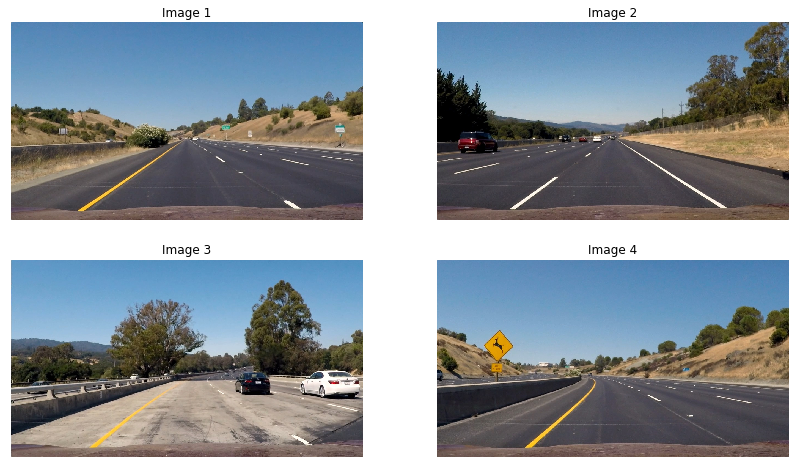

In [22]:
display_images([img1, img2, img3, img4], ["Image 1", "Image 2", "Image 3", "Image 4"], shape=(2,2), figuresize=(8,14))

# Functions for Individual Pipeline Steps

## Camera Calibration
These functions support the creation of a camera calibartion matrix and distortion coefficinets 
which are used to correct camera images so they more closely reflect real world values.  Without
the camera correction matrix and distorion coefficients, calculations based on captured camera
images would lead to innaccurate location values, and uptimately to incorrect steering instructions
for the vehicle.

shape:  (17, 2)


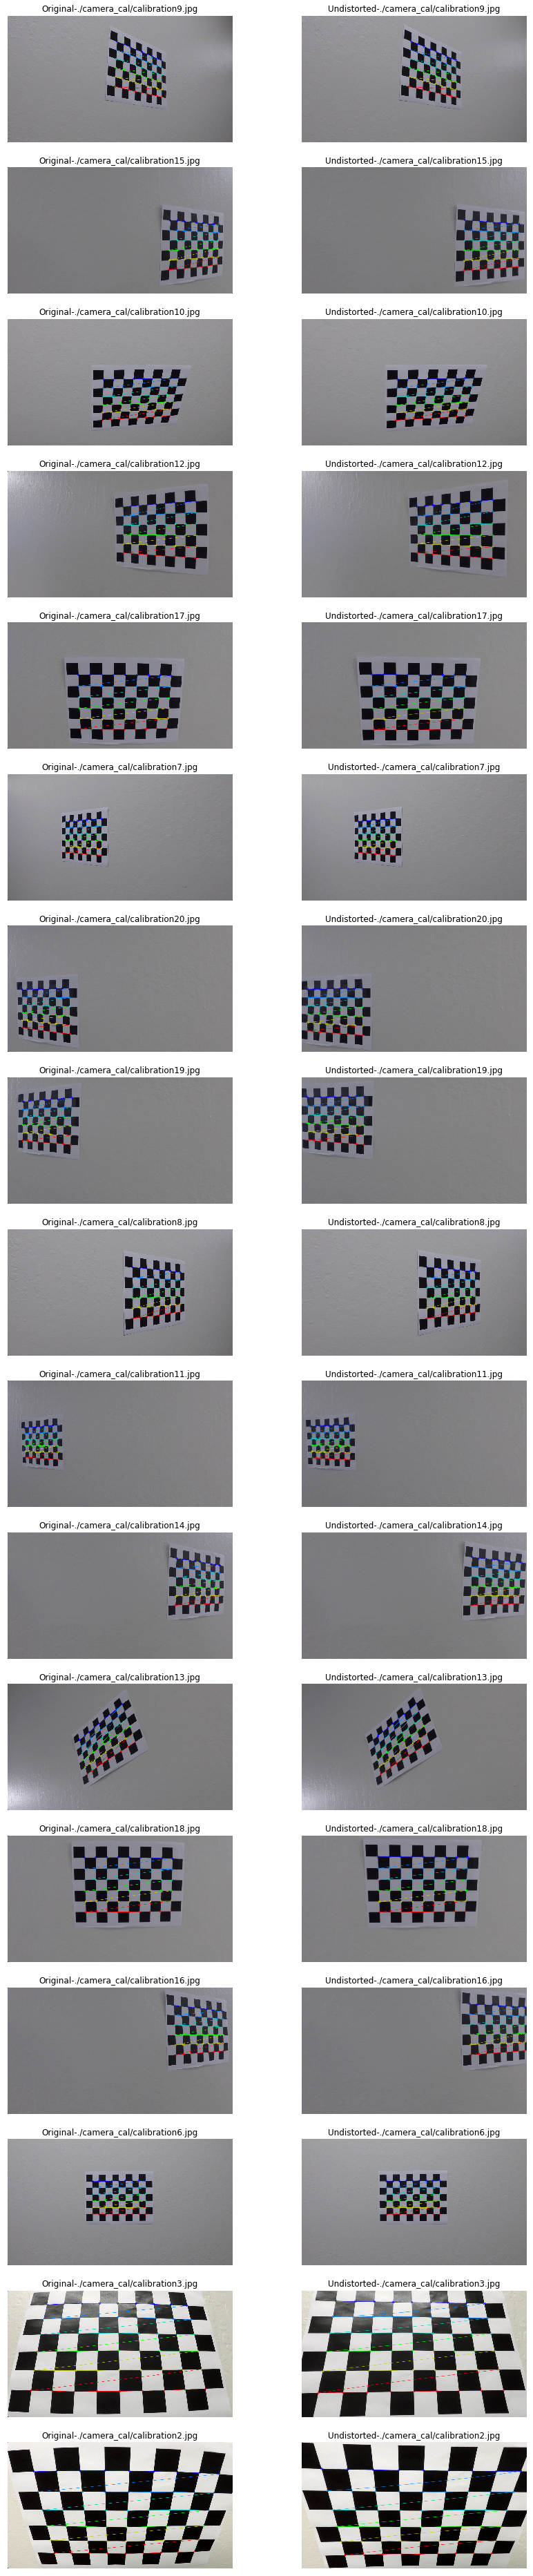

In [6]:
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] #3D points in realworld space
imgpoints = [] #2D points in image plane
originals = [] #images for illustration
captions = [] #captions for illustration
chess_dims = (CHESS_BOARD_ROWS, CHESS_BOARD_COLS)

#Prepare object points
objp = np.zeros((CHESS_BOARD_COLS*CHESS_BOARD_ROWS, 3), np.float32)
objp[:,:2] = np.mgrid[0:chess_dims[0],0:chess_dims[1]].T.reshape(-1,2) #x,y coordinates

for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chess_dims, None)

    # If corners are found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, chess_dims, corners, ret)
        ## TODO: Save the image with a logging call so it can be
        ## accessed in other contexts.
        originals.append(img)
        captions.append('Original-'+fname)
        captions.append('Undistorted-'+fname)
        
# Calibrate the camera
ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Create a list of undistorted images
dst = [cv2.undistort(img, mtx, dist, None, mtx) for img in originals]
images = list(chain(*zip(originals, dst)))

# Undistort an image
## TODO: Display a grid of all calibration images with their corrections
#dst = cv2.undistort(img, mtx, dist, None, mtx)
#display_images(images, ["Original", "Undistorted"], figuresize=(4,14))
display_images(images, captions, shape=(len(originals),2), figuresize=(4*len(originals),14))

## Apply Distortion Correction to Raw Images
These functions apply the distortion coefficients calculated during camera calibration to be used to correct each new camera frame.  Close inspection of the corrected image reveals that points near the periphery of
the image have been shifted outward from the center in both the x and y directions in proportion to their distance from the center.  The two red dots in the images below are located at the same coordinates in each respective image.  Objects at those locations have clearly shifted radially.

shape:  (1, 2)


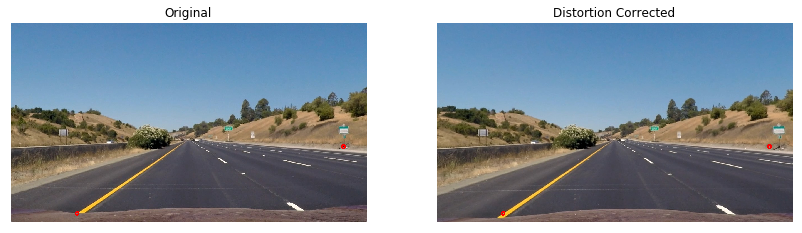

In [14]:
img = mpimg.imread("./test_images/straight_lines1.jpg")
sample_pts = [(237, 688), (1195, 448)]
img_copy = img.copy()
dst = cv2.undistort(img_copy, mtx, dist, None, mtx)
draw_circles(img, sample_pts, [6,6], [(255,0,0),(255,0,0)])
draw_circles(dst, sample_pts, [6,6], [(255,0,0),(255,0,0)])
display_images([img, dst], ['Original', 'Distortion Corrected'], figuresize=(4,14))

## Perspective Transform
Apply a perspective transform to rectify the binary image.  This produces a "birds-eye view" of the scene instead
of the view as seen by a driver from behind the steering wheel.  Such a view is useful because accurate measurements
can be pulled directly from such a transformed image just as if it were a local map of the road section located
directly in from of the car.

Note the circles in the images below.  Their distortion in the transformed image emphasize the extent to which the farthest points in the original image have been dispersed.

shape:  (2, 2)


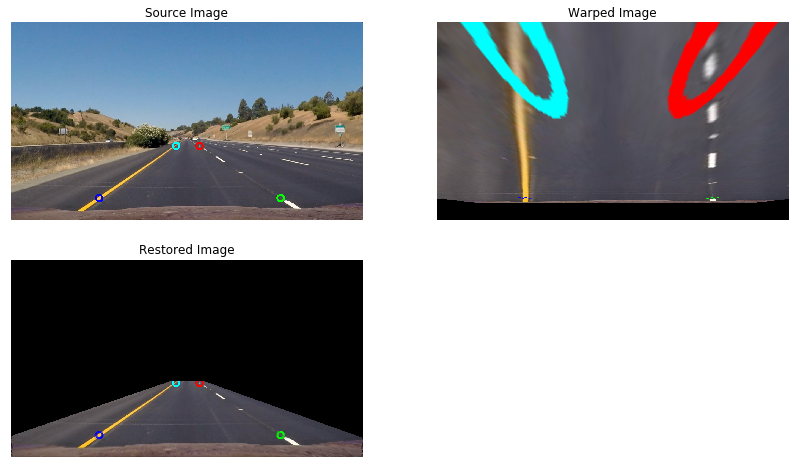

In [70]:
img = mpimg.imread("./test_images/straight_lines1.jpg")

# Four source coordinates
src = np.float32(
    [[685, 450], #top right
    [980, 640], #bottom right
    [320, 640],  #bottom left
    [600, 450]]) #top left
    
dst = np.float32(
    [[1000, 150],
    [1000, 640],
    [320, 640],
    [320, 150]])

# Define perspective transform function
def warp(img, src, dst):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse by swapping the inputs
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image -- uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

marked_img = img.copy()
centers = [(int(c[0]), int(c[1])) for c in src]
blue = (0,0,255)
green = (0,255,0)
red = (255,0,0)
yellow = (0,255,255)
draw_circles(marked_img, centers, [12] * len(centers), [red, green, blue, yellow], thickness=6)

# Get perspective transform
warped_im = warp(marked_img, src=src, dst=dst)

# Transform back to original perspective
restored_im = warp(warped_im, src=dst, dst=src)

images = [marked_img, warped_im, restored_im]
captions = ['Source Image', 'Warped Image', 'Restored Image']
display_images(images, captions, shape=(2,2), figuresize=(8,14))

# Color of Lane Lines
To search for lanes in an image, it is necessary to have an idea of the colors of the lane lines.  Below is an analysis of the hues of the yellow and white lane lines in a few images.  Note that samples are taken in both sun and shade to help isolate those characteristics which are most stable as light levels change. 

In [170]:
def make_patch(point=(0,0), shape=(3,3)):
    """
    Make an nxn patch centered on a point.  Shape should have odd dimensions.
    """
    rows = range(-(shape[0]-1)//2, (shape[0]-1)//2 + 1)
    cols = range(-(shape[1]-1)//2, (shape[1]-1)//2 + 1)
    offsets = np.array(np.reshape([(x,y) for x in rows for y in cols], (shape[0] * shape[1], 2)))
    
    return point + offsets
    
print(make_patch(point=(10, 200), shape=(3,3)))

[[  9 199]
 [  9 200]
 [  9 201]
 [ 10 199]
 [ 10 200]
 [ 10 201]
 [ 11 199]
 [ 11 200]
 [ 11 201]]


[(457, 727), (458, 727), (459, 727), (457, 728), (458, 728), (459, 728), (457, 729), (458, 729), (459, 729)]
rgb_pix.shape:  (3, 3, 3)
[array([255, 242, 225], dtype=uint8), array([255, 253, 236], dtype=uint8), array([255, 253, 236], dtype=uint8), array([224, 211, 194], dtype=uint8), array([250, 237, 220], dtype=uint8), array([255, 253, 236], dtype=uint8), array([205, 192, 175], dtype=uint8), array([224, 211, 194], dtype=uint8), array([252, 239, 222], dtype=uint8)]
hsv_pix:  [[[ 17  30 255]
  [ 27  19 255]
  [ 27  19 255]]

 [[ 17  34 224]
  [ 17  31 250]
  [ 27  19 255]]

 [[ 17  37 205]
  [ 17  34 224]
  [ 17  30 252]]]


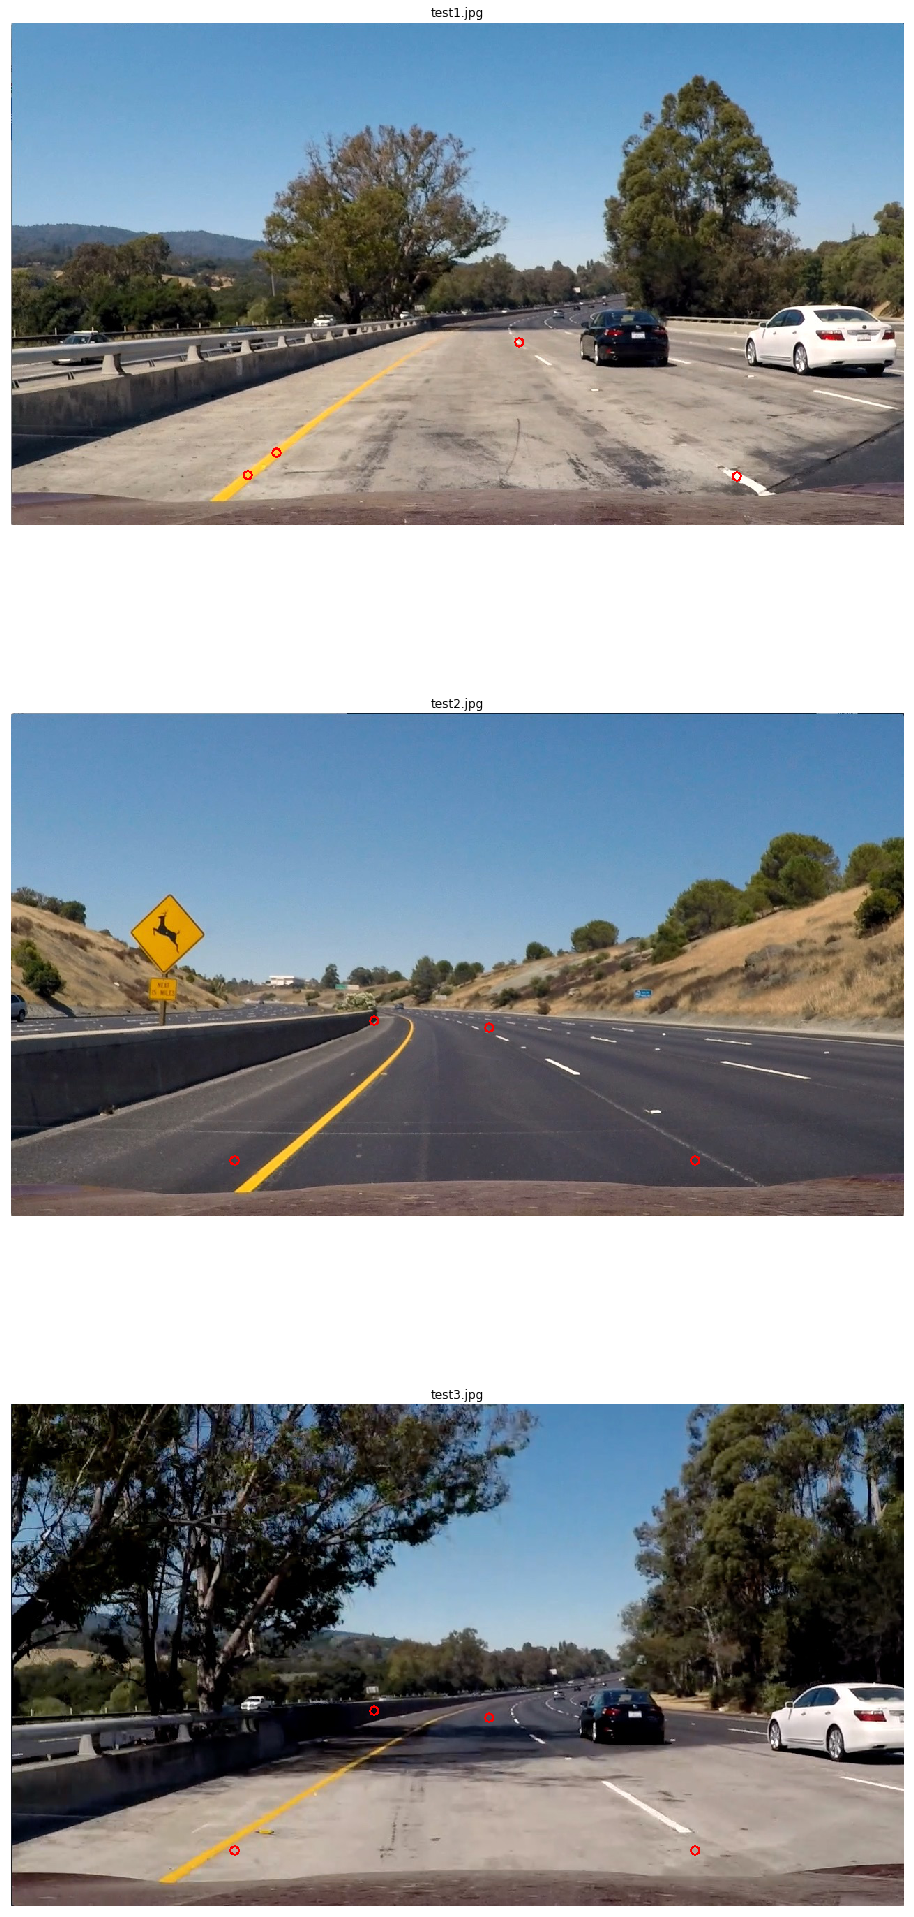

In [219]:
img1 = mpimg.imread("./test_images/test1.jpg")
img2 = mpimg.imread("./test_images/test2.jpg")
img3 = mpimg.imread("./test_images/test5.jpg")

# Isolate 3x3 patches in each image representative of lane line colors
img1_yellow_1 = (339, 648) #bottom left
img1_yellow_2 = (380, 616) #top left
img1_white_1 = (1040, 650) #bottom right
img1_white_2 = (728, 458) #top right
img2_yellow_1 = (320, 640) #bottom left
img2_yellow_2 = (520, 440) #top left
img2_white_1 = (980, 640) #bottom right
img2_white_2 = (685, 450) #top right
img3_yellow_1 = (320, 640) #bottom left
img3_yellow_2 = (520, 440) #top left
img3_white_1 = (980, 640) #bottom right
img3_white_2 = (685, 450) #top right

#patches = np.ndarray(shape=(3,2,2,3,3,2), dtype=np.int32) #3x2x2x3x3x2 = images X colors  X patches X rows X cols x points
patches = np.ndarray(shape=(3,2,2,9,2), dtype=np.int32) #3x2x2x9x2 = images X colors  X patches X (rows*cols) x points
patches[0,0,0,:,:] = make_patch(img1_yellow_1)
patches[0,0,1,:,:] = make_patch(img1_yellow_2)
patches[0,1,0,:,:] = make_patch(img1_white_1)
patches[0,1,1,:,:] = make_patch(img1_white_2)
patches[1,0,0,:,:] = make_patch(img2_yellow_1)
patches[1,0,1,:,:] = make_patch(img2_yellow_2)
patches[1,1,0,:,:] = make_patch(img2_white_1)
patches[1,1,1,:,:] = make_patch(img2_white_2)
patches[2,0,0,:,:] = make_patch(img3_yellow_1)
patches[2,0,1,:,:] = make_patch(img3_yellow_2)
patches[2,1,0,:,:] = make_patch(img3_white_1)
patches[2,1,1,:,:] = make_patch(img3_white_2)
#print(patches[0,0,1])
patch_points = [(pt[1], pt[0]) for pt in patches[0,1,1]]
print(patch_points)
rgb_pix = np.array([img1[p] for p in patch_points]).reshape(3,3,-1)
print("rgb_pix.shape: ", rgb_pix.shape)
print([img1[p] for p in patch_points])
hsv_pix = cv2.cvtColor(rgb_pix, cv2.COLOR_RGB2HSV)
print("hsv_pix: ", hsv_pix)


red = (255,0,0)

draw_circles(img1, [img1_yellow_1, img1_yellow_2, img1_white_1, img1_white_2], [6] * 4, [red] * 4, thickness=2)
draw_circles(img2, [img2_yellow_1, img2_yellow_2, img2_white_1, img2_white_2], [6] * 4, [red] * 4, thickness=2)
draw_circles(img3, [img3_yellow_1, img3_yellow_2, img3_white_1, img3_white_2], [6] * 4, [red] * 4, thickness=2)

images = [img1, img2, img3]
captions = ['test1.jpg', 'test2.jpg', 'test3.jpg']
display_images(images, captions, shape=(3,1), figuresize=(36, 16))

## Thresholded Image
Use color transforms, gradients, etc., to create a thresholded binary image.  Various methods of color space tranformation and gradient analysis can be used to highlight regions in the image where lane line markings are
potentially located.

shape:  (2, 3)


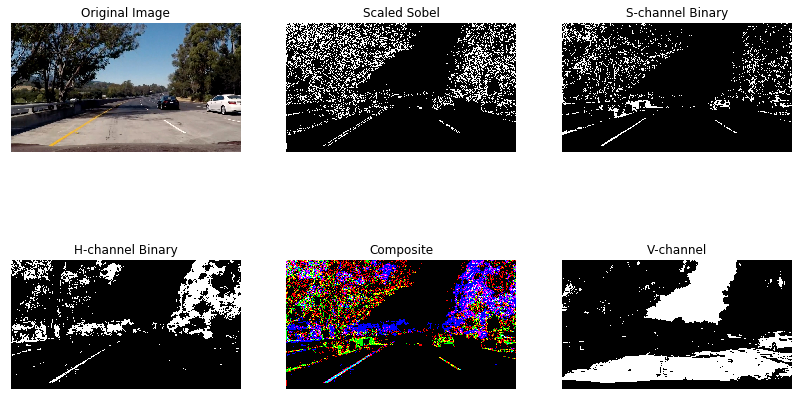

In [39]:
def thresholds(img, s_thresh=(170, 255), v_thresh=(170, 255), h_thresh=(20, 30), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_h = hls[:,:,0]
    hls_l = hls[:,:,1]
    hls_s = hls[:,:,2]
    
    # Convert to HSV color space and separate the channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_h = hsv[:,:,0]
    hsv_s = hsv[:,:,1]
    hsv_v = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(hls_s, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold HSV S channel
    s_binary = np.zeros_like(hls_s)
    s_binary[(hls_s >= s_thresh[0]) & (hls_s <= s_thresh[1])] = 1
    
    # Threshold HSV H channel
    v_binary = np.zeros_like(hsv_v)
    v_binary[(hsv_v >= v_thresh[0]) & (hsv_v <= v_thresh[1])] = 1

    h_binary = np.zeros_like(hls_h)
    h_binary[(hls_h >= h_thresh[0]) & (hls_h <= h_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack((sxbinary, s_binary, h_binary)) * 255
    return color_binary, sxbinary, s_binary, h_binary, v_binary

img = mpimg.imread("./test_images/test5.jpg")
    
clr_bin, sx_sobel, s_binary, h_binary, v_binary = thresholds(img)

imgs = [img, sx_sobel, s_binary, h_binary, clr_bin, v_binary]
captions = ['Original Image', 'Scaled Sobel', 'S-channel Binary', 'H-channel Binary', 'Composite', 'V-channel']
display_images(imgs, captions, shape=(2,3), figuresize=(8,14))

## Lane Boundaries
Detect lane pixels and fit to find the left and right lane boundaries.

## Lane Curvature and Vehicle Position
Determine the curvature of the lane and vehicle position with respect to center.  Lane curvature is determined by fitting the lane pixels detected in the previous step to a second order polynomial (a parabola).  The coefficients of the polynomial can them be used to trace out the lane edge and serve as a bound for highlighting the body of the lane.

Vehicle position is calculated by determining how far left or right of the image center each lane line lies.  If they both lie an equal distance away from the lane center, then the software deduces that the vehicle is driving in the center of the lane.  Of course, this deduction is based on the assumption that the camera is located in the center of the vehicle's dash and is pointing exactly straaight ahead.  In practice, the position and orientation of the camera will need to be calibrated prior of system operation.

## Warp Lane Boundaries Back Onto Original Image
Once the lane boundaries have been accurately detected using the warped ("bird's eye view") image, it must be
warped back onto the original image using a transform which is essentially the inverse of the original transform.  This provides us with the scene as would be observed by a driver.

## Display Lane Boundaries
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Line Class
This class holds useful details about the history of a line or curve, as in a left or right lane line.

# Test helper functions and Line Class

# Test Images

In [6]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'test4.jpg',
 'test1.jpg',
 'test6.jpg',
 'test5.jpg',
 'test3.jpg']

In [8]:
os.listdir("output_images/")

['save_output_here.txt']

# Lane Finding Pipeline
## Requirements
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [11]:
def image_pipeline(initial_image, outFileName=None, thickness=6, includeHough=False):
    pass



# Use The Lane Finding Pipeline

In [ ]:
inDir = "test_images/"
outDir = "test_images_output/"

image_file_list = os.listdir(inDir)

#create a multi-plot figure
## TODO: Consider building a display class to
## declutter logic that otherwise has nothing
## to do with displaying figures.
nRows, nCols = len(image_file_list), 3
fig = plt.figure(figsize=(30, 30))
fig.tight_layout()
fig.suptitle('Highlighting Lane Lines', fontsize=26)

for i in range(len(image_file_list)):
    ## TODO: Consider an architecture which decouples image data from the underlying source
    ## of that data.  This will allow a pipeline like this to be more easily used
    ## in embedded systems which may not operate on a file system.  What is needed is a
    ## container for an image which insulates the rest of the system from the image's
    ## origin and history.
    fname = image_file_list[i]
    output_file = os.path.join(outDir, fname)
    image = mpimg.imread(inDir +fname)
    highlightedLanes = image_pipeline(image, outFileName=output_file)
    
    ## Again, a class or function is needed to remove these output details
    ## from the main application logic.  This system ought to be able
    ## to run in an embedded environment where image displays may be
    ## unnecessary.  One thought is to add images to a list, then
    ## reshape the list to match the desired layout, then call add_subplot
    ## based on the array shape.
    
    # Add original image to the plot
    a = fig.add_subplot(nRows, nCols, i * nCols + 1)
    imgplot = plt.imshow(image)
    a.set_title(fname, fontsize=16)
    
    # Add hough image to the plot
    a = fig.add_subplot(nRows, nCols, i *nCols + 2)
    imgplot = plt.imshow(hough_img)
    a.set_title(fname + " - Hough", fontsize=16)
    
    # Add highlighted image to the plot
    a = fig.add_subplot(nRows, nCols, i * nCols + 3)
    imgplot = plt.imshow(highlightedLanes)
    a.set_title(fname + " - Highlighted", fontsize=16)


# Test on Videos

Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.

If you get an error that looks like this:

NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
Follow the instructions in the error message and check out this forum post for more troubleshooting tips across operating systems.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    highlightedLanes = image_pipeline(image, thickness=6)
    
    # you should return the final output (image where lines are drawn on lanes
    return highlightedLanes

# Test the Pipeline on a Video

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(1,4)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


Play the video inline...

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

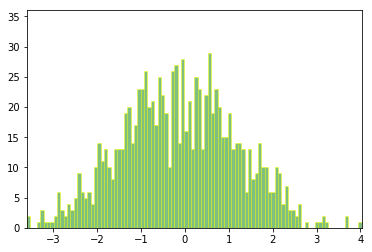

In [5]:
"""
==================
Animated histogram
==================

Use a path patch to draw a bunch of rectangles for an animated histogram.
"""
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from IPython.display import HTML

# Fixing random state for reproducibility
np.random.seed(19680801)

# histogram our data with numpy
data = np.random.randn(1000)
n, bins = np.histogram(data, 100)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

###############################################################################
# Here comes the tricky part -- we have to set up the vertex and path codes
# arrays using ``plt.Path.MOVETO``, ``plt.Path.LINETO`` and
# ``plt.Path.CLOSEPOLY`` for each rect.
#
# * We need 1 ``MOVETO`` per rectangle, which sets the initial point.
# * We need 3 ``LINETO``'s, which tell Matplotlib to draw lines from
#   vertex 1 to vertex 2, v2 to v3, and v3 to v4.
# * We then need one ``CLOSEPOLY`` which tells Matplotlib to draw a line from
#   the v4 to our initial vertex (the ``MOVETO`` vertex), in order to close the
#   polygon.
#
# .. note::
#
#   The vertex for ``CLOSEPOLY`` is ignored, but we still need a placeholder
#   in the ``verts`` array to keep the codes aligned with the vertices.
nverts = nrects * (1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom

###############################################################################
# To animate the histogram, we need an ``animate`` function, which generates
# a random set of numbers and updates the locations of the vertices for the
# histogram (in this case, only the heights of each rectangle). ``patch`` will
# eventually be a ``Patch`` object.
patch = None


def animate(i):
    # simulate new data coming in
    data = np.random.randn(1000)
    n, bins = np.histogram(data, 100)
    top = bottom + n
    verts[1::5, 1] = top
    verts[2::5, 1] = top
    return [patch, ]

###############################################################################
# And now we build the `Path` and `Patch` instances for the histogram using
# our vertices and codes. We add the patch to the `Axes` instance, and setup
# the `FuncAnimation` with our animate function.
fig, ax = plt.subplots()
barpath = path.Path(verts, codes)
patch = patches.PathPatch(
    barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())

ani = animation.FuncAnimation(fig, animate, 100, repeat=False, blit=True)
plt.show()

In [29]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
h = ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

In [30]:
ani